In [12]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from scipy.fftpack import fft
from qiskit import QuantumCircuit, Aer, execute
from qiskit.extensions import Initialize
import time as t

In [13]:
# Step 1: 获取实际地震波数据
def fetch_seismic_data():
    client = Client("IRIS")
    starttime = UTCDateTime("2020-01-01T00:00:00")  # 选择特定日期的地震数据
    endtime = starttime + 300  # 采集300秒的数据

    # 获取地震波形数据，使用某个地震台站的数据
    st = client.get_waveforms(network="IU", station="ANMO", location="00", channel="BHZ",
                              starttime=starttime, endtime=endtime)

    # 将数据滤波
    st.detrend(type="linear")
    st.filter("highpass", freq=0.1)  # 高通滤波去除低频噪音
    tr = st[0]
    seismic_wave = tr.data
    sampling_rate = tr.stats.sampling_rate

    return seismic_wave, sampling_rate

In [14]:
# Step 2: 使用 FFT 分析地震波数据
def fft_analysis(seismic_wave, sampling_rate):
    N = len(seismic_wave)
    fft_result = fft(seismic_wave)
    fft_frequencies = np.fft.fftfreq(N, d=1 / sampling_rate)

    # 只取前半部分的频率
    fft_result = np.abs(fft_result[:N // 2])
    fft_frequencies = fft_frequencies[:N // 2]

    return fft_frequencies, fft_result


# Step 3: 使用 QFT 分析地震波数据
def quantum_fourier_transform(n_qubits):
    qc = QuantumCircuit(n_qubits)
    for j in range(n_qubits):
        qc.h(j)
        for k in range(j):
            qc.cp(np.pi / float(2 ** (j - k)), k, j)
    qc.barrier()
    for qubit in range(n_qubits // 2):
        qc.swap(qubit, n_qubits - qubit - 1)
    return qc


In [15]:

def prepare_amplitude_encoding(samples):
    norm = np.linalg.norm(samples)
    normalized_samples = samples / norm
    return normalized_samples


def quantum_amplitude_encoding_circuit(amplitudes, n_qubits):
    # 构造振平编码的初始化电路
    qc = QuantumCircuit(n_qubits)
    init_gate = Initialize(amplitudes)
    qc.append(init_gate, range(n_qubits))
    qc.barrier()
    return qc


def improved_qft_analysis(seismic_wave, n_qubits=8):
    # 选择前 2^n 个样本数据，进行量化并对一化
    samples = seismic_wave[:2 ** n_qubits]
    amplitudes = prepare_amplitude_encoding(samples)

    # 振平编码电路构建
    qft_circuit = quantum_amplitude_encoding_circuit(amplitudes, n_qubits)

    # 构建 QFT 电路
    qft_circuit.compose(quantum_fourier_transform(n_qubits), inplace=True)

    # 绘制 QFT 电路图
    plt.figure(figsize=(12, 6))
    qft_circuit.draw(output='mpl')
    plt.title("Quantum Fourier Transform Circuit")
    plt.show()

    # 模拟执行量子电路
    simulator = Aer.get_backend('statevector_simulator')
    job = execute(qft_circuit, simulator)
    result = job.result()
    statevector = result.get_statevector()

    # 提取频率信息
    frequencies = np.abs(statevector) * 1000
    return frequencies


In [16]:
# Step 4: 绘制地震波形图
def plot_seismic_wave(time, seismic_wave):
    plt.figure(figsize=(10, 6))
    plt.plot(time, seismic_wave, label="Seismic Wave")
    plt.title("Seismic Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()


# Step 5: 绘制 FFT 频谱图
def plot_fft_spectrum(fft_frequencies, fft_result):
    plt.figure(figsize=(10, 6))
    plt.plot(fft_frequencies, fft_result)
    plt.title("FFT Frequency Spectrum of Seismic Wave")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()


# Step 6: 绘制 QFT 频谱图
def plot_qft_spectrum(frequencies_qft):
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies_qft)
    plt.title("QFT Frequency Spectrum of Seismic Wave")
    plt.xlabel("Quantum Frequency Index")
    plt.ylabel("Magnitude")
    plt.show()

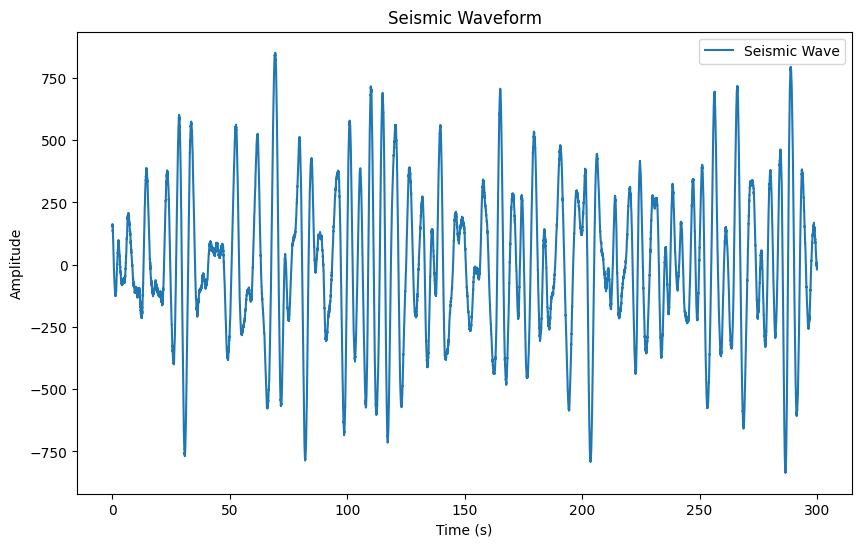

FFT Analysis Time: 0.0005 seconds


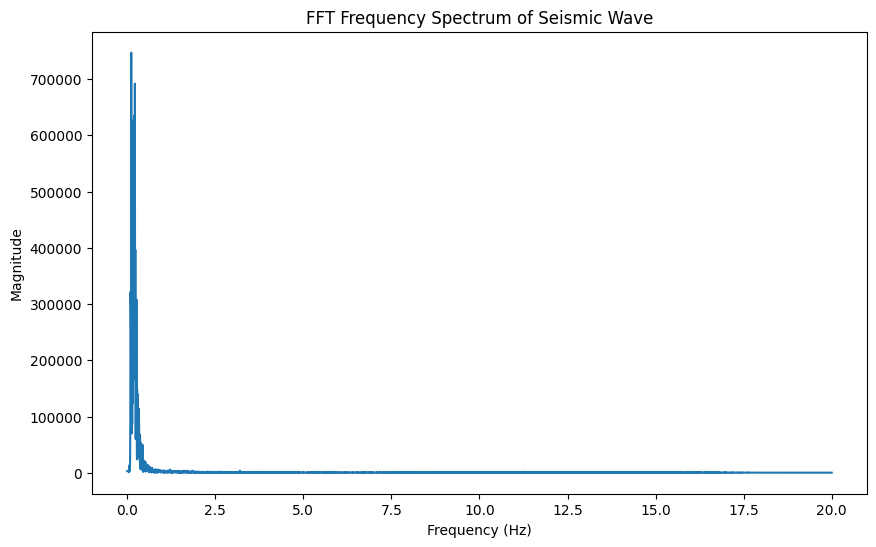

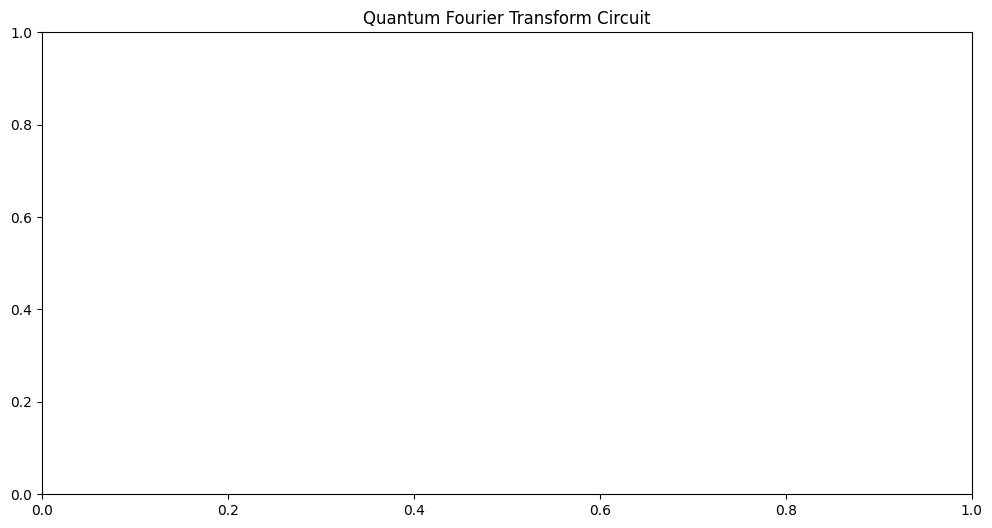

QFT Analysis Time: 0.7099 seconds


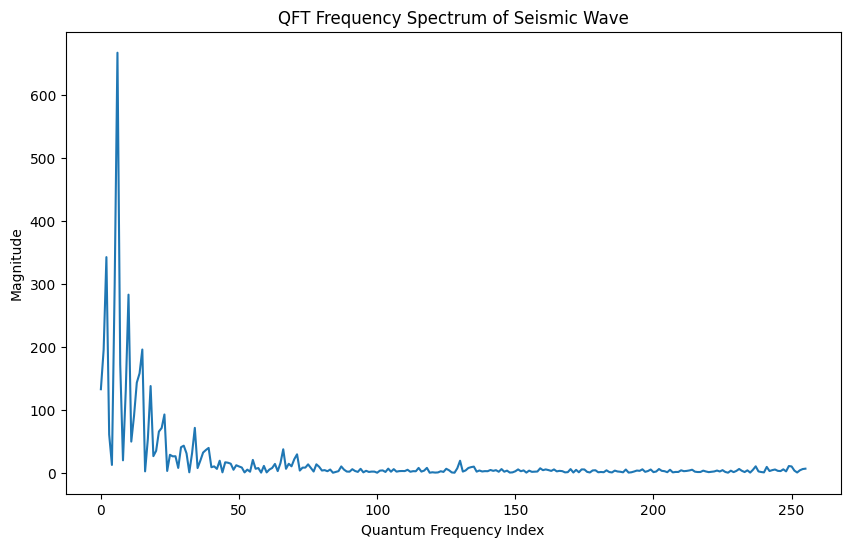

In [11]:
# Step 7: 主函数
def main():
    # 获取地震波数据
    seismic_wave, sampling_rate = fetch_seismic_data()

    # 时间轴
    time = np.arange(0, len(seismic_wave) / sampling_rate, 1 / sampling_rate)

    # 绘制地震波形
    plot_seismic_wave(time, seismic_wave)

    # 使用 FFT 分析
    start_time = t.perf_counter()
    fft_frequencies, fft_result = fft_analysis(seismic_wave, sampling_rate)
    fft_time = t.perf_counter() - start_time
    print(f"FFT Analysis Time: {fft_time:.4f} seconds")

    # 绘制 FFT 频谱
    plot_fft_spectrum(fft_frequencies, fft_result)

    # 使用 QFT 分析
    start_time = t.perf_counter()
    frequencies_qft = improved_qft_analysis(seismic_wave, n_qubits=8)
    qft_time = t.perf_counter() - start_time
    print(f"QFT Analysis Time: {qft_time:.4f} seconds")

    # 绘制 QFT 频谱
    plot_qft_spectrum(frequencies_qft)


# 执行主函数
if __name__ == "__main__":
    main()